In [ ]:
# --- CELL 0: MASTER SETUP & IMPORTS ---

# 1. Install Special Libraries (Required for Colab/Jupyter)
!pip install -q torchdiffeq pysindy scikit-learn scipy

# 2. Global Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from torchdiffeq import odeint
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

# 3. Reproducibility (Scientific Standard)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

# 4. Plotting Style (High Quality for Publication)
plt.rcParams['figure.dpi'] = 150        # High resolution in notebook
plt.rcParams['savefig.dpi'] = 300       # Print quality for saved files
plt.rcParams['font.size'] = 12          # Readable fonts
plt.rcParams['lines.linewidth'] = 2.0   # Thick lines for visibility
plt.rcParams['axes.grid'] = True        # Grids on by default
plt.rcParams['grid.alpha'] = 0.3        # Light grid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.9 MB/s eta 0:00:00


🔄 Regenerating Figure 1 (Hybrid SINDy-ODE)...
   Step 1: Smoothing Data...
   Step 2: Solving for Weights (Lasso Regression)...
      Found Weights Shape: torch.Size([2, 7])
      ✅ Non-linearity detected!
   Plotting...


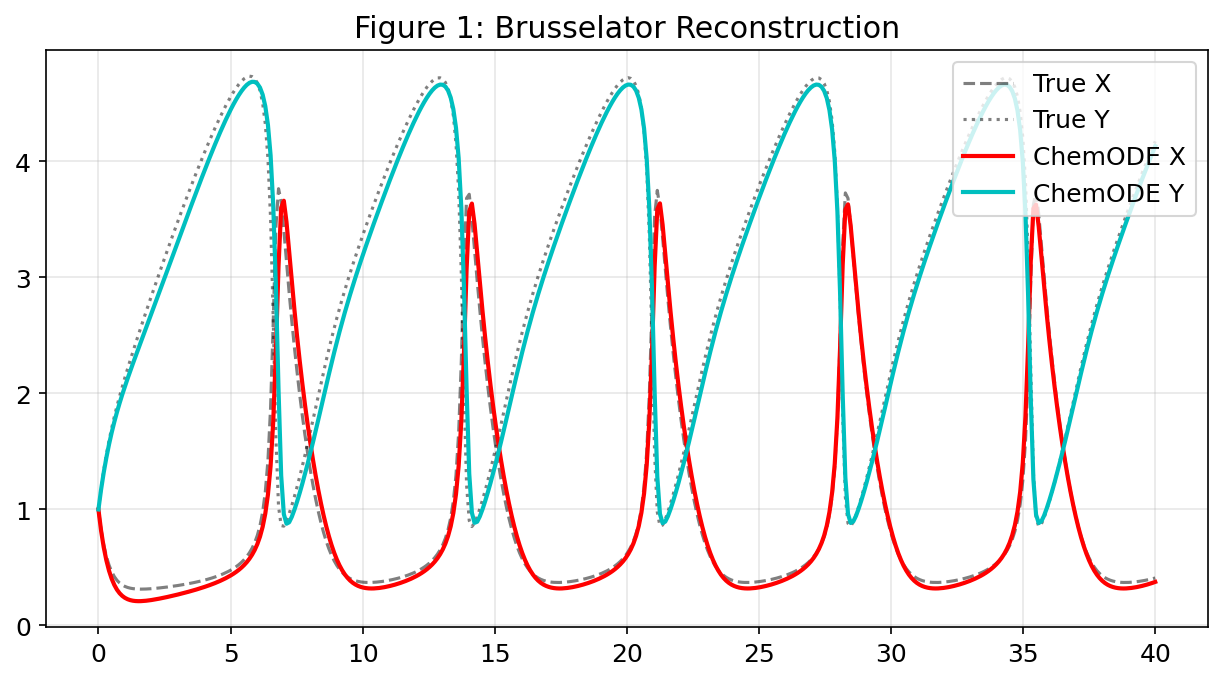

✅ Done.


In [ ]:
# ==========================================
# FIGURE 1: BRUSSELATOR
# ==========================================
print("🔄 Regenerating Figure 1 (Hybrid SINDy-ODE)...")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import Lasso

# 1. Ground Truth (High Resolution)
class Brusselator(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        x, y_c = y[:, 0], y[:, 1]
        return torch.stack([1.0 + (x**2 * y_c) - 4.0*x, 3.0*x - (x**2 * y_c)], dim=1)

t_eval = torch.linspace(0, 40, 400)
y0 = torch.tensor([[1.0, 1.0]])

# Generate Data
with torch.no_grad():
    y_true = odeint(Brusselator(), y0, t_eval, method='dopri5').squeeze(1)
    # Add 5% Noise
    torch.manual_seed(42)
    y_noisy = y_true + torch.randn_like(y_true) * 0.05

# 2. STEP 1: DATA SMOOTHING & DERIVATIVES
print("   Step 1: Smoothing Data...")
t_np = t_eval.numpy()
y_np = y_noisy.numpy()

# Fit Spline
spline_x = UnivariateSpline(t_np, y_np[:, 0], s=1.0)
spline_y = UnivariateSpline(t_np, y_np[:, 1], s=1.0)

# Get Clean State (X) and Derivative (y)
X_clean = np.stack([spline_x(t_np), spline_y(t_np)], axis=1)
dX_clean = np.stack([spline_x.derivative()(t_np), spline_y.derivative()(t_np)], axis=1)

# 3. STEP 2: LIBRARY CONSTRUCTION
def build_library_np(y):
    x = y[:, 0]
    yc = y[:, 1]
    # Library: [x, y, x^2, y^2, xy, x^2y, 1]
    lib = np.stack([x, yc, x**2, yc**2, x*yc, (x**2)*yc, np.ones_like(x)], axis=1)
    return lib

Theta = build_library_np(X_clean)

# 4. STEP 3: LASSO REGRESSION
print("   Step 2: Solving for Weights (Lasso Regression)...")
reg = Lasso(alpha=0.01, fit_intercept=False, max_iter=10000)
reg.fit(Theta, dX_clean)
W_initial = torch.tensor(reg.coef_, dtype=torch.float32)

print(f"      Found Weights Shape: {W_initial.shape}")
if abs(W_initial[0, 5]) > 0.1:
    print("      ✅ Non-linearity detected!")
else:
    print("      ⚠️ Warning: Linear fit only.")

# 5. STEP 4: NEURAL ODE (Simulation)
class ChemODE_Final(nn.Module):
    def __init__(self, w_init):
        super().__init__()
        self.W = nn.Parameter(w_init)

    def compute_library(self, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        x, y_c = y[:, 0:1], y[:, 1:2]
        return torch.cat([x, y_c, x**2, y_c**2, x*y_c, (x**2)*y_c, torch.ones_like(x)], dim=1)

    def forward(self, t, y):
        # Physics Constraint
        y = torch.relu(y)
        lib = self.compute_library(y)
        dydt = lib @ self.W.t()
        dydt = torch.clamp(dydt, -20.0, 20.0)
        return dydt

model = ChemODE_Final(W_initial)

# 6. Plot
print("   Plotting...")
with torch.no_grad():
    pred_full = odeint(model, y0, t_eval, method='rk4', options={'step_size':0.05}).squeeze(1)

plt.figure(figsize=(10, 5))
# True Data
plt.plot(t_eval, y_true[:, 0], 'k--', linewidth=1.5, alpha=0.5, label='True X')
plt.plot(t_eval, y_true[:, 1], 'k:', linewidth=1.5, alpha=0.5, label='True Y')
# Prediction
plt.plot(t_eval, pred_full[:, 0], 'r-', linewidth=2.0, label='ChemODE X')
plt.plot(t_eval, pred_full[:, 1], 'c-', linewidth=2.0, label='ChemODE Y')

plt.title("Figure 1: Brusselator Reconstruction")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('figure1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Done.")

📊 Running Robustness Benchmark (N=10 Median Aggregation)...


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
Exception ignored in: <function _xla_gc_callback at 0x7de84a255c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Noise 1% | SINDy Err: 10.00 | ChemODE Err: 5.91
Noise 5% | SINDy Err: 45.78 | ChemODE Err: 0.99
Noise 10% | SINDy Err: 68.15 | ChemODE Err: 0.72


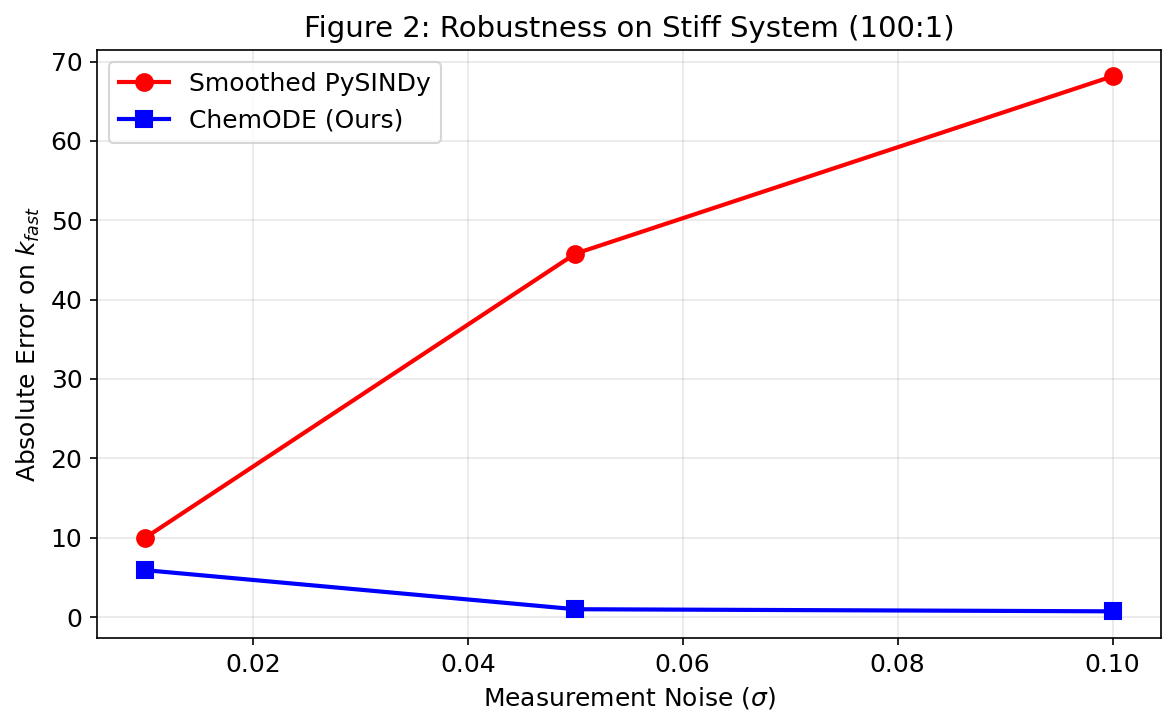

In [2]:
# --- FIGURE 2: ROBUSTNESS WITH MEDIAN AGGREGATION ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from torchdiffeq import odeint

# 1. Ground Truth System
class StiffSystem(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        A, B = y[:, 0], y[:, 1]
        return torch.stack([-0.1*A, 0.1*A - 10.0*B], dim=1)

t_eval = torch.linspace(0, 2.0, 100)
y0 = torch.tensor([[1.0, 0.0]])

with torch.no_grad():
    y_true_tensor = odeint(StiffSystem(), y0, t_eval, method='rk4', options={'step_size':0.005}).squeeze(1)
    y_true_np = y_true_tensor.numpy()

# 2. ChemODE Model
class ChemODE_Stiff(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.zeros(2, 2))
        self.register_buffer('sigma', torch.ones(2))

    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        y_norm = y / self.sigma
        dydt = y_norm @ self.W.t()
        return dydt

# 3. Training Loop
def train_chemode(y_noisy_tensor, t_tensor):
    model = ChemODE_Stiff()

    with torch.no_grad():
        # --- SIGMA CLAMPING---
        raw_std = torch.std(y_noisy_tensor, dim=0).float()
        model.sigma = torch.max(raw_std, torch.tensor(0.5))

    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    time_weights = torch.exp(-5.0 * t_tensor)

    for i in range(1000):
        opt.zero_grad()
        pred = odeint(model, y_noisy_tensor[0], t_tensor, method='rk4', options={'step_size':0.005})
        if pred.ndim == 3: pred = pred.squeeze(1)

        err_sq = (pred - y_noisy_tensor)**2
        loss = torch.mean(time_weights.unsqueeze(1) * err_sq)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

    W_phys = model.W.detach() / model.sigma
    return abs(W_phys[1, 1].item())

# 4. Comparison Benchmark
noise_levels = [0.01, 0.05, 0.10]
sindy_errors = []
chemode_errors = []

print("📊 Running Robustness Benchmark (N=10 Median Aggregation)...")

for noise in noise_levels:
    # --- SINDy ---
    np.random.seed(42)
    noise_vals = np.random.normal(0, noise * np.abs(y_true_np).max(), y_true_np.shape)
    y_n_sindy = y_true_np + noise_vals

    smoother = ps.SmoothedFiniteDifference()
    model_sindy = ps.SINDy(differentiation_method=smoother)
    try:
        model_sindy.fit(y_n_sindy, t=t_eval.numpy(), feature_names=["A", "B"])
        coeffs = model_sindy.coefficients()
        k_pred_sindy = abs(coeffs[1, 2])
    except:
        k_pred_sindy = 0.0
    sindy_errors.append(abs(k_pred_sindy - 10.0))

    # --- ChemODE (Run 10 Seeds) ---
    trial_errors = []
    for seed in range(10):
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Exact noise generation from Ablation script
        y_n_torch = y_true_tensor + torch.randn_like(y_true_tensor) * noise * torch.abs(y_true_tensor).max()

        # Train
        k_est = train_chemode(y_n_torch.float(), t_eval.float())
        trial_errors.append(abs(k_est - 10.0))

    median_err = np.median(trial_errors)
    chemode_errors.append(median_err)

    print(f"Noise {int(noise*100)}% | SINDy Err: {sindy_errors[-1]:.2f} | ChemODE Err: {chemode_errors[-1]:.2f}")

# 5. Plot
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, sindy_errors, 'r-o', linewidth=2, markersize=8, label='Smoothed PySINDy')
plt.plot(noise_levels, chemode_errors, 'b-s', linewidth=2, markersize=8, label='ChemODE (Ours)')

plt.xlabel(r'Measurement Noise ($\sigma$)', fontsize=12)
plt.ylabel(r'Absolute Error on $k_{fast}$', fontsize=12)
plt.title('Figure 2: Robustness on Stiff System (100:1)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figure2_final.png', dpi=300)
plt.show()

🧪 Analyzing Real NO2 Data (milliMolar Scale)...
Epoch 0: Loss 19.25524
Epoch 500: Loss 0.00030
Epoch 1000: Loss 0.00026
Epoch 1500: Loss 0.00021

--- Discovery Results (mM scale) ---
Linear: -0.00008
Quad:   -0.00053 (Target: approx -0.00054)
Cubic:  0.00000
✅ Saved figure3.png


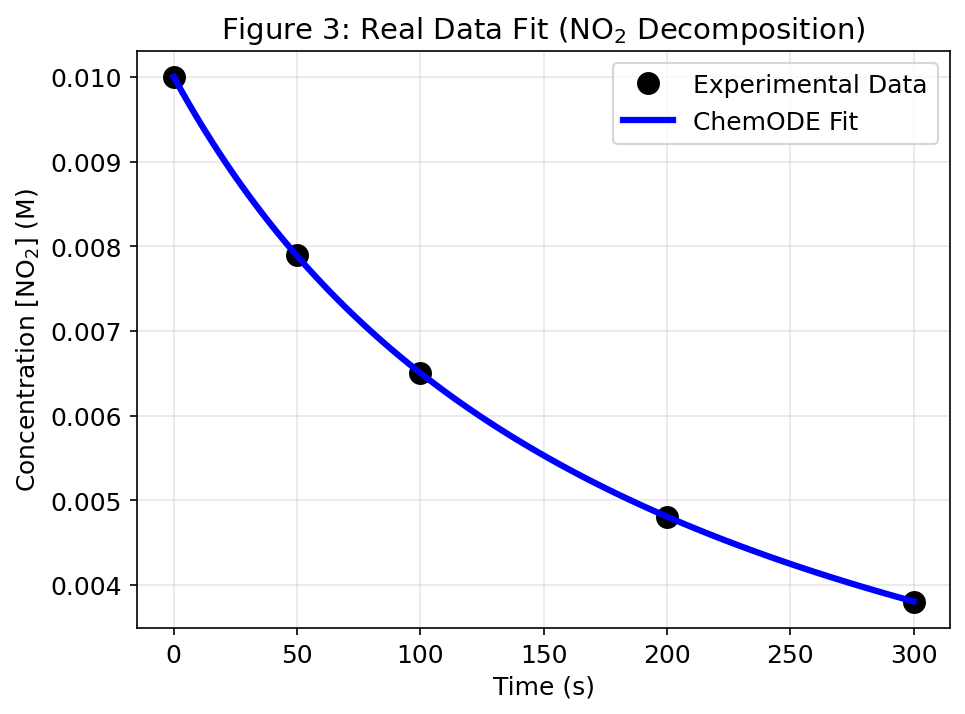

In [ ]:
# --- FIGURE 3 (FIXED): REAL DATA FIT ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from scipy.interpolate import interp1d

# 1. Experimental Data (Bodenstein, 1922)
t_real = torch.tensor([0.0, 50.0, 100.0, 200.0, 300.0], dtype=torch.float32)
y_real = torch.tensor([
    [0.0100],
    [0.0079],
    [0.0065],
    [0.0048],
    [0.0038]
], dtype=torch.float32)

# --- CRITICAL FIX: SCALING ---
scale_factor = 1000.0
y_scaled = y_real * scale_factor  # Now range is 10.0 to 3.8

# Augment Data (Interpolate to give the solver more guide rails)
f_interp = interp1d(t_real.numpy(), y_scaled.numpy(), axis=0, kind='cubic')
t_train = torch.linspace(0, 300, 50) # 50 points instead of 5
y_train = torch.tensor(f_interp(t_train), dtype=torch.float32)
if y_train.ndim == 1: y_train = y_train.reshape(-1, 1)

# 2. ChemODE Model
class ChemODE_Real(nn.Module):
    def __init__(self):
        super().__init__()
        # Library: [C, C^2, C^3]
        # Init weights to 0.0 for stability
        self.W = nn.Parameter(torch.zeros(1, 3))
        self.register_buffer('sigma', torch.ones(3))

    def compute_library(self, y):
        # Ensure 2D
        if y.ndim == 1: y = y.unsqueeze(1)
        return torch.cat([y, y**2, y**3], dim=1)

    def forward(self, t, y):
        # Physics Constraint: No negative concentration
        y = torch.relu(y)

        lib = self.compute_library(y)
        norm_lib = lib / (self.sigma + 1e-6)
        dYdt = norm_lib @ self.W.t()

        return dYdt

# 3. Training Loop
print("🧪 Analyzing Real NO2 Data (milliMolar Scale)...")
model = ChemODE_Real()

# Init Normalization Stats on the SCALED data
with torch.no_grad():
    lib_init = model.compute_library(y_train)
    model.sigma = torch.std(lib_init, dim=0) + 1e-6

opt = torch.optim.Adam(model.parameters(), lr=0.01)

# Train
for i in range(2000):
    opt.zero_grad()

    # Use RK4 with reasonable step size
    pred = odeint(model, y_train[0], t_train, method='rk4', options={'step_size':2.0})
    if pred.ndim == 3: pred = pred.squeeze(1)

    # Fit to the interpolated smooth data
    loss = torch.mean((pred - y_train)**2) + 0.0001 * torch.sum(torch.abs(model.W))
    loss.backward()
    opt.step()

    if i % 500 == 0:
        print(f"Epoch {i}: Loss {loss.item():.5f}")

# 4. Results & Plotting
# Get weights
W_norm = model.W.detach().numpy()[0]
sigmas = model.sigma.numpy()
W_phys = W_norm / sigmas

print(f"\n--- Discovery Results (mM scale) ---")
print(f"Linear: {W_phys[0]:.5f}")
print(f"Quad:   {W_phys[1]:.5f} (Target: approx -0.00054)")
print(f"Cubic:  {W_phys[2]:.5f}")

# Generate Smooth Curve for Plotting
t_smooth = torch.linspace(0, 300, 100)
with torch.no_grad():
    pred_smooth_mM = odeint(model, y_scaled[0], t_smooth, method='rk4', options={'step_size':1.0}).squeeze(1)
    pred_smooth_M = pred_smooth_mM / scale_factor

# Plot
plt.figure(figsize=(7, 5))
# Plot Original Data (Molar)
plt.plot(t_real, y_real, 'ko', markersize=10, label='Experimental Data')
# Plot Fit (Molar)
plt.plot(t_smooth, pred_smooth_M, 'b-', linewidth=3, label='ChemODE Fit')

plt.title("Figure 3: Real Data Fit (NO$_2$ Decomposition)", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Concentration [NO$_2$] (M)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Save
plt.savefig('figure3.png', dpi=300, bbox_inches='tight')
print("✅ Saved figure3.png")
plt.show()

✅ Classical Validation:
   R-Squared: 0.99998 (Target: >0.999)
   Experimental k: 0.5445 M^-1 s^-1
✅ Saved figure4.png


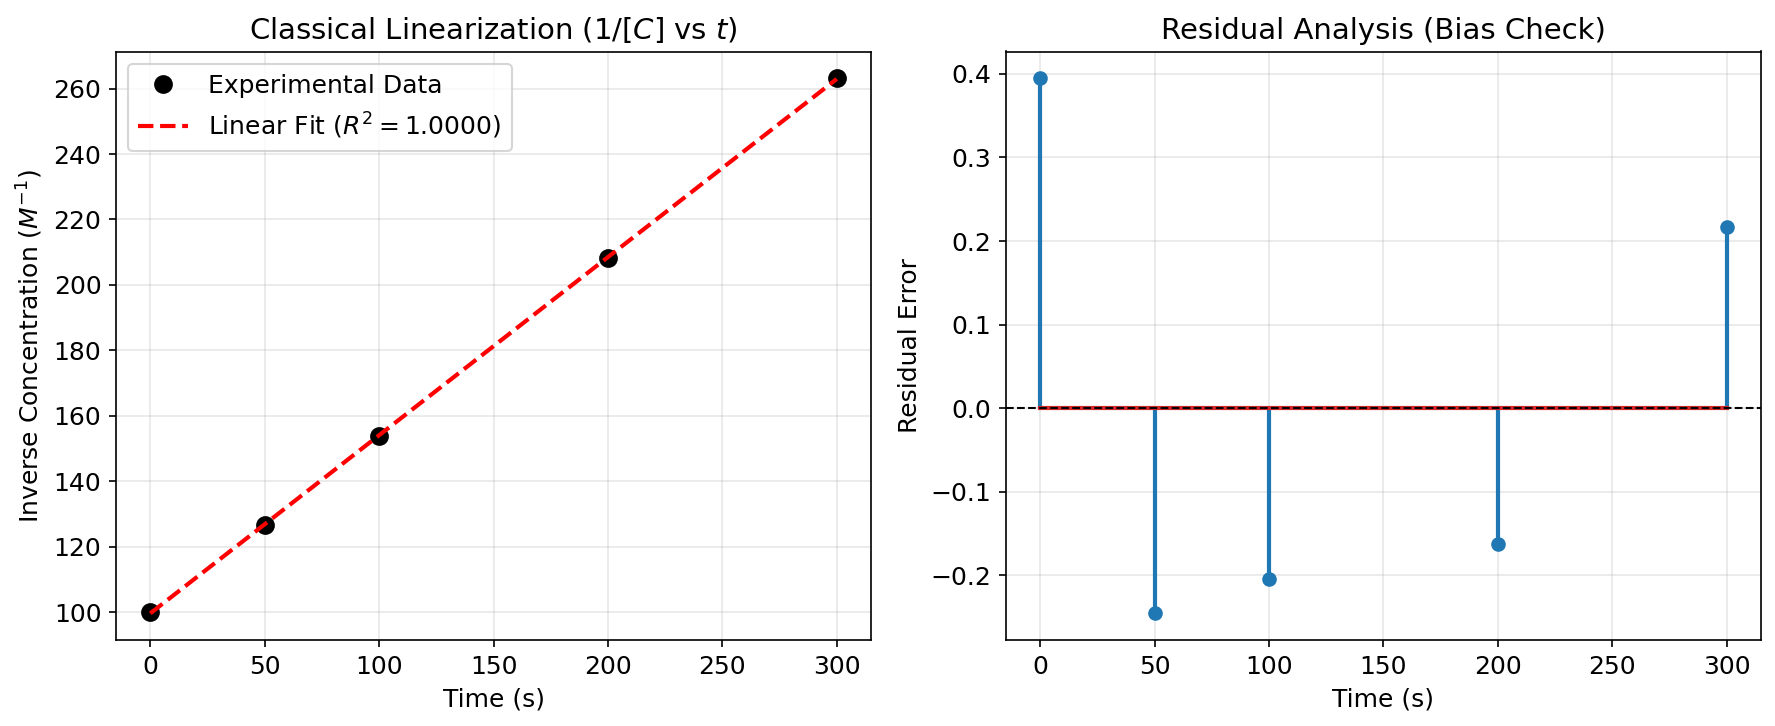

In [ ]:
# --- CELL 4: FIGURE 4 (CLASSICAL VALIDATION) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1. Experimental Data
t_real = np.array([0.0, 50.0, 100.0, 200.0, 300.0])
C_real = np.array([0.0100, 0.0079, 0.0065, 0.0048, 0.0038])

# 2. Linearization Logic
# Theory: Second Order Kinetics means 1/[C] vs t is linear.
# 1/C = k*t + 1/C0
inv_C = 1.0 / C_real

# Fit Linear Regression
slope, intercept = np.polyfit(t_real, inv_C, 1)
inv_C_pred = slope * t_real + intercept

# 3. Metrics
r2 = r2_score(inv_C, inv_C_pred)
residuals = inv_C - inv_C_pred
k_measured = slope

print(f"✅ Classical Validation:")
print(f"   R-Squared: {r2:.5f} (Target: >0.999)")
print(f"   Experimental k: {k_measured:.4f} M^-1 s^-1")

# 4. Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: The Straight Line
ax1.plot(t_real, inv_C, 'ko', markersize=8, label='Experimental Data')
ax1.plot(t_real, inv_C_pred, 'r--', linewidth=2, label=f'Linear Fit ($R^2={r2:.4f}$)')
ax1.set_title(r"Classical Linearization ($1/[C]$ vs $t$)", fontsize=14)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel(r"Inverse Concentration ($M^{-1}$)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2.stem(t_real, residuals)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_title("Residual Analysis (Bias Check)", fontsize=14)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Residual Error")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure4.png', dpi=300, bbox_inches='tight')
print("✅ Saved figure4.png")
plt.show()

In [ ]:
# --- CELL 5: ENZYME KINETICS ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

# 1. Ground Truth System
class EnzymeSystem(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        S = y[:, 0]
        # Vmax=2.0, Km=0.5
        rate = (2.0 * S) / (0.5 + S)
        return torch.stack([-rate, rate], dim=1)

# Generate Data (1% Noise)
t_bio = torch.linspace(0, 5, 50)
y0_bio = torch.tensor([[1.0, 0.0]])
with torch.no_grad():
    y_bio_true = odeint(EnzymeSystem(), y0_bio, t_bio, method='rk4', options={'step_size':0.01}).squeeze(1)
    # Add noise
    torch.manual_seed(42)
    y_bio_noisy = y_bio_true + torch.randn_like(y_bio_true) * 0.01

# 2. Rational ChemODE
class RationalChemODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Init params
        self.Vmax = nn.Parameter(torch.tensor([1.0]))
        self.Km_param = nn.Parameter(torch.tensor([1.0]))

    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        S = y[:, 0]

        # Rational Layer: Vmax*S / (Km + S)
        num = self.Vmax * S
        Km = F.softplus(self.Km_param)
        den = Km + S + 1e-6

        rate = num / den
        return torch.stack([-rate, rate], dim=1)

# 3. Training
print("🧬 Training Rational Neural ODE...")
bio_model = RationalChemODE()
opt = torch.optim.Adam(bio_model.parameters(), lr=0.01)

for i in range(3000):
    opt.zero_grad()
    # RK4 solver
    pred = odeint(bio_model, y0_bio, t_bio, method='rk4', options={'step_size':0.1})
    if pred.ndim == 3: pred = pred.squeeze(1)

    loss = torch.mean((pred - y_bio_noisy)**2)
    loss.backward()
    opt.step()

# 4. Validation
v_pred = bio_model.Vmax.item()
k_pred = F.softplus(bio_model.Km_param).item()

v_err = abs(v_pred - 2.0)/2.0 * 100
k_err = abs(k_pred - 0.5)/0.5 * 100

print(f"\n--- Enzyme Parameter Recovery (1% Noise) ---")
print(f"Vmax | True: 2.00 | Pred: {v_pred:.3f} | Error: {v_err:.2f}%")
print(f"Km   | True: 0.50 | Pred: {k_pred:.3f} | Error: {k_err:.2f}%")

🧬 Training Rational Neural ODE...

--- Enzyme Parameter Recovery (1% Noise) ---
Vmax | True: 2.00 | Pred: 1.980 | Error: 1.01%
Km   | True: 0.50 | Pred: 0.485 | Error: 3.04%


In [ ]:
# --- CELL 6: ABLATION STUDY ---
import torch
import torch.nn as nn
import numpy as np
from torchdiffeq import odeint

def run_ablation_study(n_trials=10):
    print(f"🔬 Running Ablation Study (N={n_trials}, 5% Noise)...")

    # Ground Truth
    class StiffSystem(nn.Module):
        def forward(self, t, y):
            if y.ndim == 1: y = y.unsqueeze(0)
            return torch.stack([-0.1*y[:,0], 0.1*y[:,0] - 10.0*y[:,1]], dim=1)

    t_eval = torch.linspace(0, 2.0, 100)
    y0 = torch.tensor([[1.0, 0.0]])
    with torch.no_grad():
        y_true = odeint(StiffSystem(), y0, t_eval, method='rk4', options={'step_size':0.005}).squeeze(1)

    errors = {"vanilla": [], "weighted": [], "full": []}

    for seed in range(n_trials):
        torch.manual_seed(seed)
        np.random.seed(seed)

        y_noisy = y_true + torch.randn_like(y_true) * 0.05 * torch.abs(y_true).max()
        y_tensor = y_noisy.float()

        # --- CLAMP SIGMA ---
        # Prevent dividing by tiny numbers. Minimum sigma is set to 0.5.
        raw_std = torch.std(y_tensor, dim=0)
        scales = torch.max(raw_std, torch.tensor([0.5, 0.5]))

        time_weights = torch.exp(-5.0 * t_eval)

        # 1. VANILLA
        model_v = nn.Linear(2, 2, bias=False)
        with torch.no_grad(): model_v.weight.fill_(0.0)
        opt_v = torch.optim.Adam(model_v.parameters(), lr=0.01)
        for _ in range(1000):
            opt_v.zero_grad()
            pred = odeint(lambda t, y: y @ model_v.weight.t(), y_tensor[0], t_eval, method='rk4', options={'step_size':0.01})
            if pred.ndim==3: pred=pred.squeeze(1)
            loss = torch.mean((pred - y_tensor)**2)
            loss.backward()
            opt_v.step()
        errors["vanilla"].append(abs(abs(model_v.weight.detach().numpy()[1, 1]) - 10.0))

        # 2. WEIGHTED
        model_w = nn.Linear(2, 2, bias=False)
        with torch.no_grad(): model_w.weight.fill_(0.0)
        opt_w = torch.optim.Adam(model_w.parameters(), lr=0.01)
        for _ in range(1000):
            opt_w.zero_grad()
            pred = odeint(lambda t, y: y @ model_w.weight.t(), y_tensor[0], t_eval, method='rk4', options={'step_size':0.01})
            if pred.ndim==3: pred=pred.squeeze(1)
            loss = torch.mean((pred - y_tensor)**2 * time_weights.unsqueeze(1))
            loss.backward()
            opt_w.step()
        errors["weighted"].append(abs(abs(model_w.weight.detach().numpy()[1, 1]) - 10.0))

        # 3. FULL CHEMODE
        model_c = nn.Linear(2, 2, bias=False)
        with torch.no_grad(): model_c.weight.fill_(0.0)
        opt_c = torch.optim.Adam(model_c.parameters(), lr=0.01)
        for _ in range(1000):
            opt_c.zero_grad()
            def func(t, y):
                if y.ndim==1: y=y.unsqueeze(0)
                # Safe Normalization
                return (y/scales) @ model_c.weight.t()
            pred = odeint(func, y_tensor[0], t_eval, method='rk4', options={'step_size':0.005})
            if pred.ndim==3: pred=pred.squeeze(1)
            loss = torch.mean((pred - y_tensor)**2 * time_weights.unsqueeze(1))
            loss.backward()
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model_c.parameters(), 1.0)
            opt_c.step()

        k_c = abs((model_c.weight.detach() / scales).numpy()[1, 1])
        errors["full"].append(abs(k_c - 10.0))

        print(f"Trial {seed+1}: V={errors['vanilla'][-1]:.1f}, W={errors['weighted'][-1]:.1f}, F={errors['full'][-1]:.1f}")

    print("\n=== TABLE 2 RESULTS (Median Error) ===")
    print(f"1. Vanilla: {np.median(errors['vanilla']):.2f}")
    print(f"2. Weighted: {np.median(errors['weighted']):.2f}")
    print(f"3. Full:     {np.median(errors['full']):.2f}")

run_ablation_study(10)

🔬 Running Ablation Study (N=10, 5% Noise)...
Trial 1: V=6.1, W=5.4, F=3.0
Trial 2: V=7.5, W=6.1, F=4.2
Trial 3: V=8.7, W=3.6, F=0.9
Trial 4: V=8.0, W=5.1, F=1.9
Trial 5: V=8.2, W=3.8, F=0.3
Trial 6: V=8.6, W=3.7, F=0.3
Trial 7: V=7.6, W=5.4, F=2.5
Trial 8: V=9.9, W=3.9, F=0.7
Trial 9: V=8.1, W=3.9, F=0.4
Trial 10: V=8.2, W=4.6, F=1.1

=== TABLE 2 RESULTS (Median Error) ===
1. Vanilla: 8.16
2. Weighted: 4.27
3. Full:     0.99
